In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [70]:
labels = ['even', 'weighted', 'absent']
img_size = 224

def get_data(data_dir):
	data = [] 
	for label in labels: 
		path = os.path.join(data_dir, label)
		class_num = labels.index(label)
		for img in os.listdir(path):
			try:
				img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
				resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
				data.append([resized_arr, class_num])
			except Exception as e:
				print(e)
	return data


train = get_data('data/input/train')
val = get_data('data/input/test')

<Axes: ylabel='Count'>

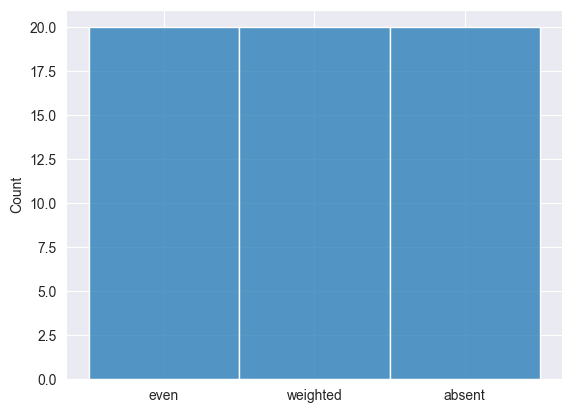

In [71]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("even")
    if(i[1] == 1):
        l.append("weighted")
    if(i[1] == 2):
        l.append("absent")
sns.set_style('darkgrid')
sns.histplot(l)

Text(0.5, 1.0, 'even')

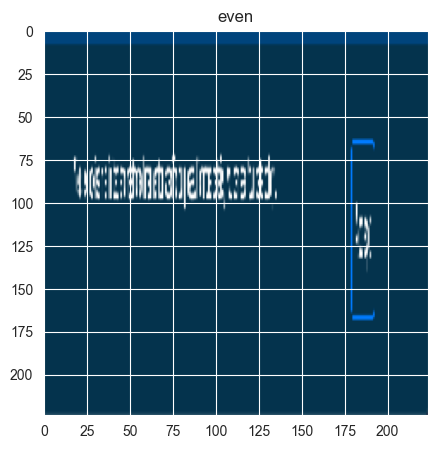

In [72]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[0][1]])

In [73]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [74]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [75]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 64)      

In [77]:
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500


2023-04-17 09:58:59.422155: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 2 which is outside the valid range of [0, 2).  Label values: 2 1 1 1 1 2 1 2 0 2 1 0 2 0 1 1 0 2 2 0 2 2 1 2 0 0 1 0 2 2 1 1


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/nl/jzj263x945x2tkv9y6dnj06c0000gn/T/ipykernel_24852/3729185573.py", line 4, in <module>
      history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Users/jurisadorna/199_ariadne/envs/janus/lib/python3.9/site-packages/keras/backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 2 which is outside the valid range of [0, 2).  Label values: 2 1 1 1 1 2 1 2 0 2 1 0 2 0 1 1 0 2 2 0 2 2 1 2 0 0 1 0 2 2 1 1
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_2521]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


NameError: name 'history' is not defined